In [1]:
from bluemath_tk.predictor.xwt import XWT

dwt = XWT(steps={}).load_model("outputs/dwt_model_aveiro.pkl")
awt = XWT(steps={}).load_model("outputs/awt_model_aveiro.pkl")

2025-03-31 18:33:42,530 - XWT - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.
2025-03-31 18:33:42,554 - XWT - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.


In [2]:
dwt_kma_bmus_df = dwt.kma_bmus.copy()
dwt_kma_bmus_df.index.name = "time"
dwt_kma_bmus_df.columns = ["bmus"]
dwt_kma_bmus_ds = dwt_kma_bmus_df.to_xarray()
dwt_kma_bmus_ds

<xarray.Dataset> Size: 192kB
Dimensions:  (time: 16032)
Coordinates:
  * time     (time) datetime64[s] 128kB 1980-01-01 1980-01-02 ... 2023-11-22
Data variables:
    bmus     (time) int32 64kB 33 33 17 17 18 18 17 36 36 ... 9 9 4 9 9 9 22 22

In [3]:
covariates_ds = (
    awt.steps.get("pca")
    .pcs.resample(time="1D")
    .pad()
    .rename({"n_component": "n_covariates", "PCs": "cov_norm"})
    .drop(["stds", "kma_bmus"])
)
covariates_ds = (covariates_ds - covariates_ds.mean(dim="time")) / covariates_ds.std(
    dim="time"
)
covariates_ds["cov_names"] = (("n_covariates"), [f"PC{i}" for i in range(1, 4)])
covariates_ds

<xarray.Dataset> Size: 503kB
Dimensions:       (time: 15707, n_covariates: 3)
Coordinates:
  * time          (time) datetime64[ns] 126kB 1980-01-01 ... 2023-01-01
  * n_covariates  (n_covariates) int64 24B 0 1 2
Data variables:
    cov_norm      (time, n_covariates) float64 377kB -0.0849 1.258 ... -0.332
    cov_names     (n_covariates) <U3 36B 'PC1' 'PC2' 'PC3'

In [4]:
from bluemath_tk.teslakit.alr import ALR_WRP

alr_terms = {
    "mk_order": 3,
    "constant": True,
    "long_term": False,
    "seasonality": (True, [2, 4, 6]),
    "covariates": (
        True,
        covariates_ds.sel(time=dwt_kma_bmus_ds.time, method="nearest"),
    ),
}

alr_model = ALR_WRP(
    p_base="/workspaces/BlueMath/climate_services/MUSCLE.Aveiro/outputs/dwt_alr"
)
alr_model.SetFitData(
    cluster_size=dwt.num_clusters,
    xds_bmus_fit=dwt_kma_bmus_ds,
    d_terms_settings=alr_terms,
)
alr_model.FitModel(max_iter=1000)


Fitting autoregressive logistic model ...
Optimization done in 133.77 seconds



/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


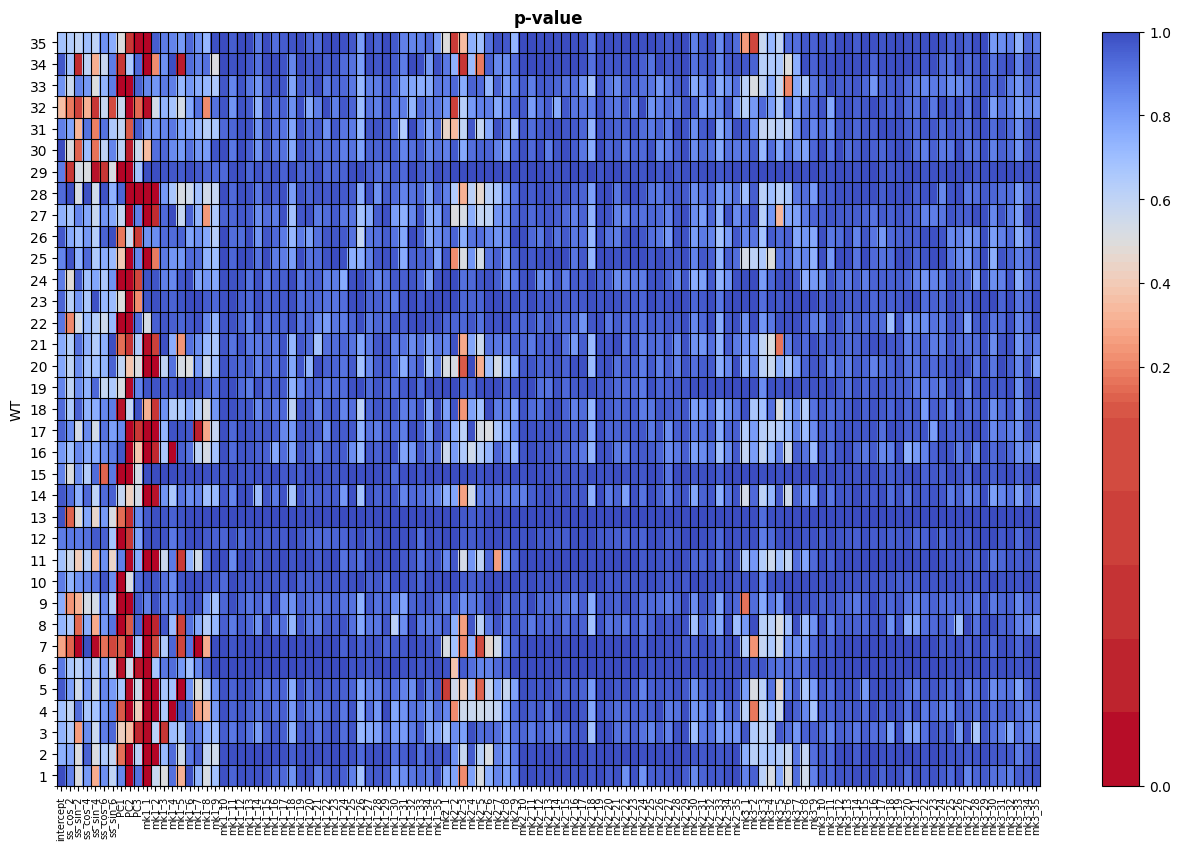

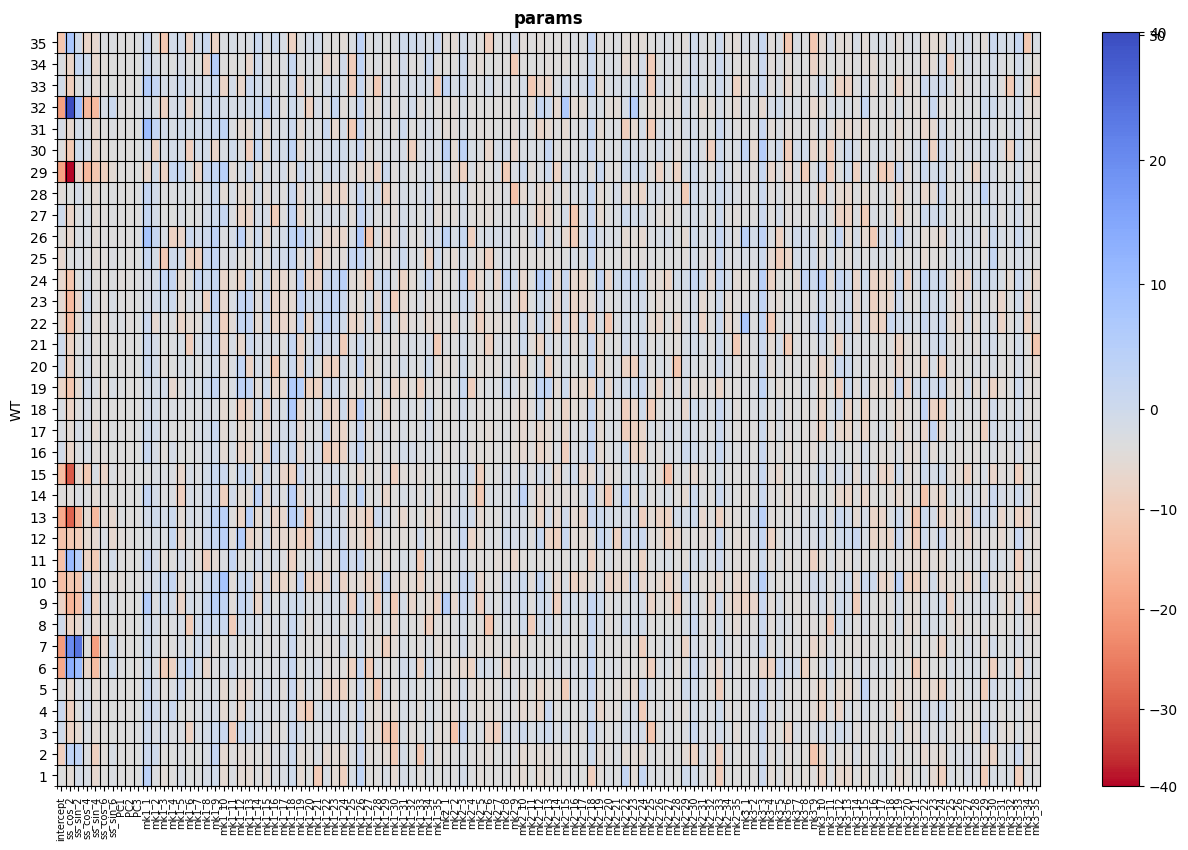

In [5]:
# Plot model p-values and params

alr_model.Report_Fit()

In [6]:
import xarray as xr

simulated_annual_PCs = (
    xr.open_dataset("outputs/awt_alr/simulated_PCs.nc").resample(time="1D").pad()
)
simulated_annual_PCs

<xarray.Dataset> Size: 89MB
Dimensions:     (time: 36891, n_sim: 100, n_covariates: 3)
Coordinates:
  * time        (time) datetime64[ns] 295kB 1999-01-01 1999-01-02 ... 2100-01-01
  * n_sim       (n_sim) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Dimensions without coordinates: n_covariates
Data variables:
    cov_values  (n_sim, time, n_covariates) float64 89MB ...

In [7]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate

# launch simulation
simulated_daily_bmus = alr_model.Simulate(
    num_sims=5,
    time_sim=simulated_annual_PCs.time.values,
    xds_covars_sim=simulated_annual_PCs,
)
simulated_daily_bmus

ALR model fit   : 1980-01-01 --- 2023-11-22
ALR model sim   : 1999-01-01 --- 2100-01-01

Launching 5 simulations...

Sim. Num. 005 (Covs. 005): 100%|██████████| 36888/36888 [00:21<00:00, 1749.00it/s]



<xarray.Dataset> Size: 2MB
Dimensions:      (time: 36891, n_sim: 5)
Coordinates:
  * time         (time) datetime64[ns] 295kB 1999-01-01 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 1MB 33 33 33 33 33 17 ... 18 17 18 32 8 26
    ofbmus_sims  (time, n_sim) bool 184kB False False False ... False False

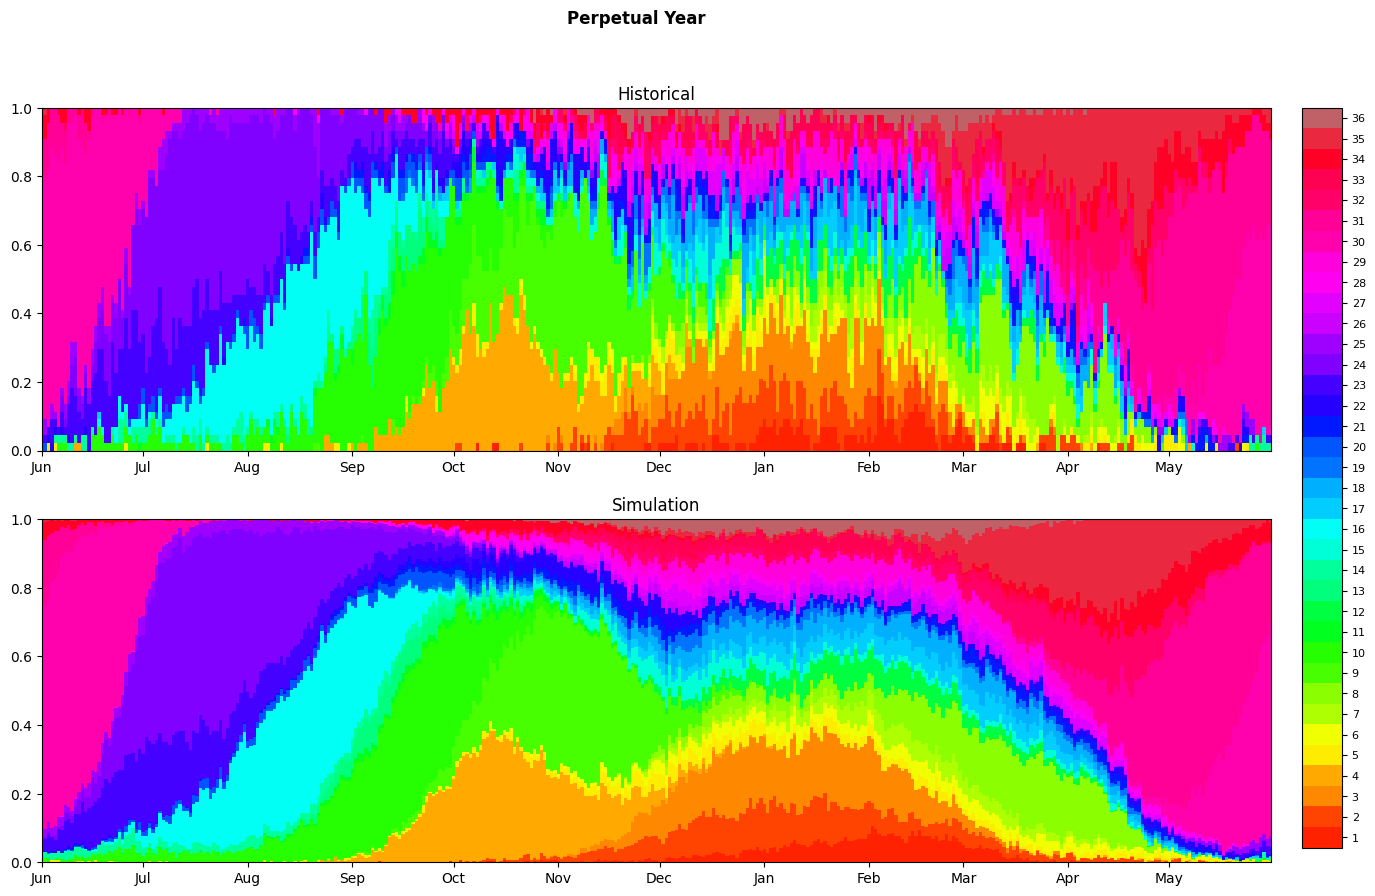

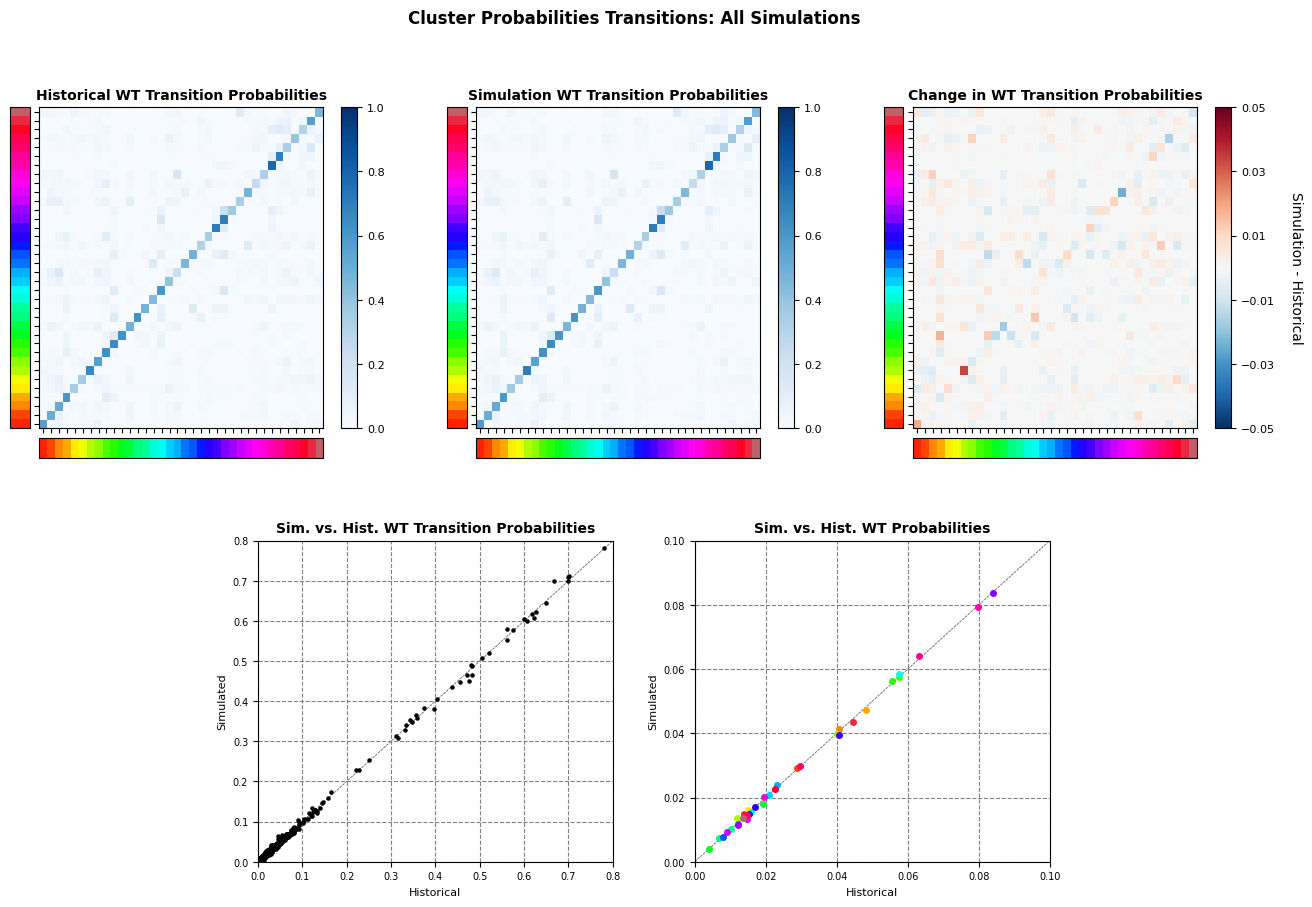

In [8]:
# show sim report

_fig = alr_model.Report_Sim(py_month_ini=6)